## Fit and analyze decoder models
The next step of the BehaveNet pipeline is using simultaneously recorded neural activity to predict behavior. Specifically, we can predict either of our compressed descriptions of behavior: the convolutional autoencoder latents or the ARHMM states.

We use linear models or feedforward deep networks to predict the state or latents for a given frame given a window of neural activity. We then compare our predictions to baseline (aka chance) performance. We can also use the convolutional autoencoder to convert the predicted latents into a full predicted behavioral video and compare to the original behavior.


<br>

### Contents
* [Decoding discrete states](#Decoding-discrete-states)
* [Decoding continuous latents](#Decoding-continuous-latents)
* [Assess decoding performance](#Assess-decoding-performance)
* [Plot true vs predicted latents](#Plot-true-vs-predicted-latents)
* [Make real vs predicted movies](#Make-real-vs-predicted-movies)


In [1]:
import pickle
import scipy
import scipy.io as sio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 18, 'figure.figsize': (16, 8)})
from behavenet import get_user_dir, make_dir_if_not_exists
from behavenet.data.utils import get_transforms_paths
from behavenet.data.utils import load_labels_like_latents
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.plotting.arhmm_utils import *
import torch
save_outputs = True  # true to save figures/movies to user's figure directory
format = 'png'  # figure format ('png' | 'jpeg' | 'pdf'); movies saved as mp4


## Decoding discrete (ARHMM) states

First copy the example json files ``decoding_ae_model.json``, ``decoding_arhmm_model.json``, ``decoding_training.json`` and ``decoding_compute.json`` into your ``.behavenet`` directory, ``cd`` to the ``behavenet`` directory in the terminal, and run:

```console
$: python behavenet/fitting/decoding_grid_search.py --data_config ~/.behavenet/decoding_data.json --model_config ~/.behavenet/decoding_arhmm_model.json --training_config ~/.behavenet/decoding_training.json --compute_config ~/.behavenet/decoding_compute.json
```

[Back to contents](#Contents)

## Decoding continuous states (AE latents)

```console
$: python behavenet/fitting/decoding_grid_search.py --data_config ~/.behavenet/decoding_data.json --model_config ~/.behavenet/decoding_ae_model.json --training_config ~/.behavenet/decoding_training.json --compute_config ~/.behavenet/decoding_compute.json
```

[Back to contents](#Contents)

## Assess decoding performance
We want to examine how our predictions of both discrete states and continuous states compare to a baseline chance performance.

[Back to contents](#Contents)

In [2]:
from behavenet.fitting.utils import get_subdirs
from behavenet.plotting.ae_utils import plot_neural_reconstruction_traces_wrapper
from behavenet.fitting.utils import build_data_generator

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'ae_experiment_name': 'latent_search',
    'model_class': 'neural-ae',
    'model_type': 'ff',
    'experiment_name': 'grid_search',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'n_ae_latents': 9,
    'rng_seed_data': 0,
    'trial_splits': '8;1;1;0',
    'subsample_idxs_name': 'n1300_sample_9',
    'subsample_group_0': 'samples',
    'subsample_group_1': 'subsamples',
    'subsample_method': 'single',
    'device': 'cpu',
    'as_numpy': True,
    'batch_load': False,
    'train_frac': 1.0,
    'version': 0,
}

get_lab_example(hparams, 'dipoppa', 'MD0ST5_1')
sess_idx = 0 
hparams['session_dir'], sess_ids = get_session_dir(hparams)
expt_dir = get_expt_dir(hparams)
hparams['expt_dir'] = expt_dir

import copy
from behavenet.data.utils import get_transforms_paths
from behavenet.data.data_generator import ConcatSessionsGenerator

# ae data
hparams_ae = copy.copy(hparams)
hparams_ae['experiment_name'] = hparams['ae_experiment_name']
hparams_ae['model_class'] = hparams['ae_model_class']
hparams_ae['model_type'] = hparams['ae_model_type']

ae_transform, ae_path = get_transforms_paths('ae_latents', hparams_ae, None)

# ae predictions data
hparams_dec = copy.copy(hparams)
hparams_dec['neural_ae_experiment_name'] = hparams['decoder_experiment_name']
hparams_dec['neural_ae_model_class'] = hparams['decoder_model_class']
hparams_dec['neural_ae_model_type'] = hparams['decoder_model_type']
ae_pred_transform, ae_pred_path = get_transforms_paths(
 'neural_ae_predictions', hparams_dec, None)

signals = ['ae_latents', 'ae_predictions']
transforms = [ae_transform, ae_pred_transform]
paths = [ae_path, ae_pred_path]

data_generator = ConcatSessionsGenerator(
 hparams['data_dir'], [hparams],
 signals_list=[signals], transforms_list=[transforms], paths_list=[paths],
 device='cpu', as_numpy=False, batch_load=False, rng_seed=0)

In [6]:
ae_pred_transform, ae_pred_path

(None,
 '/rigel/free/users/jf3338/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/n1300_sample_9-single/grid_search/version_0/dipoppa_full_trial_MD0ST5_1_predictions.pkl')

In [13]:
preds = np.load(ae_pred_path, allow_pickle=True)
preds

{'predictions': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]

In [69]:
from behavenet.fitting.utils import get_best_model_and_data
from behavenet.models.decoders import Decoder
model, data = get_best_model_and_data(hparams, Decoder)

Loading model defined in /rigel/free/users/jf3338/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/n1300_sample_9-single/grid_search/version_0/meta_tags.pkl


(134, 9)


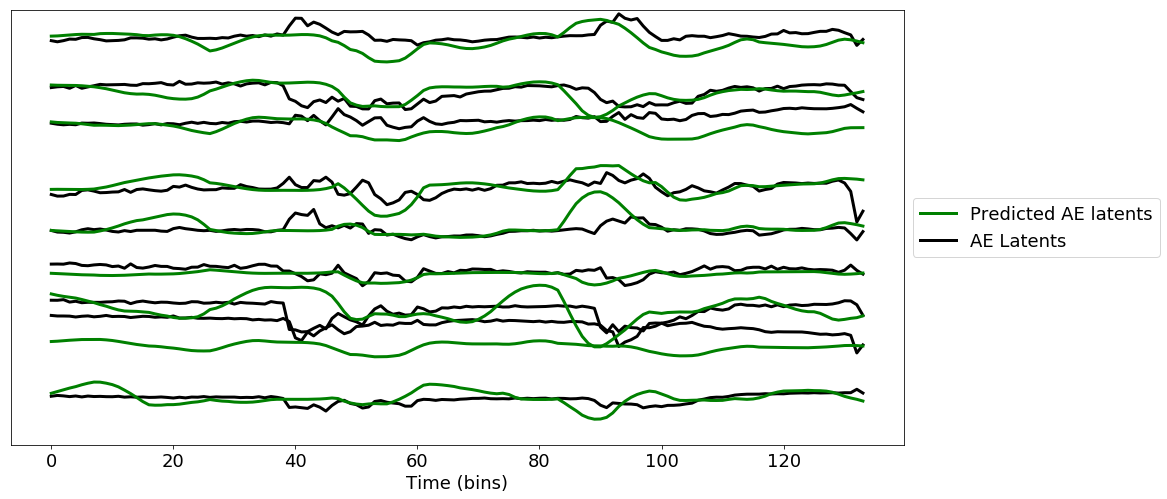

In [139]:
idxs = data.datasets[0].batch_idxs['test']
plot_error_thresh = 9
max_lags = 8

with torch.no_grad():
    for i, trial in enumerate(idxs):
        
        traces_ae = data.datasets[0][trial]['ae_latents']
        neural = data.datasets[0][trial]['neural']
    
        out, _ = model(neural)
        
        pred = out[max_lags:-max_lags]
        latents = traces_ae[max_lags:-max_lags]
        error = torch.nn.functional.mse_loss(pred, latents)
        
        if error.item() < plot_error_thresh:
            plot_real_vs_predicted(latents, pred)

In [64]:
from behavenet.fitting.eval import export_predictions

pred_files = export_predictions(data, model)
predictions = np.load(pred_files[0], allow_pickle=True)

saving predictions 1 of 1 to /rigel/free/users/jf3338/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/n1300_sample_9-single/grid_search/version_0/dipoppa_full_trial_MD0ST5_1_predictions.pkl


tensor(10.8770)


In [67]:
predictions['predictions']

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan

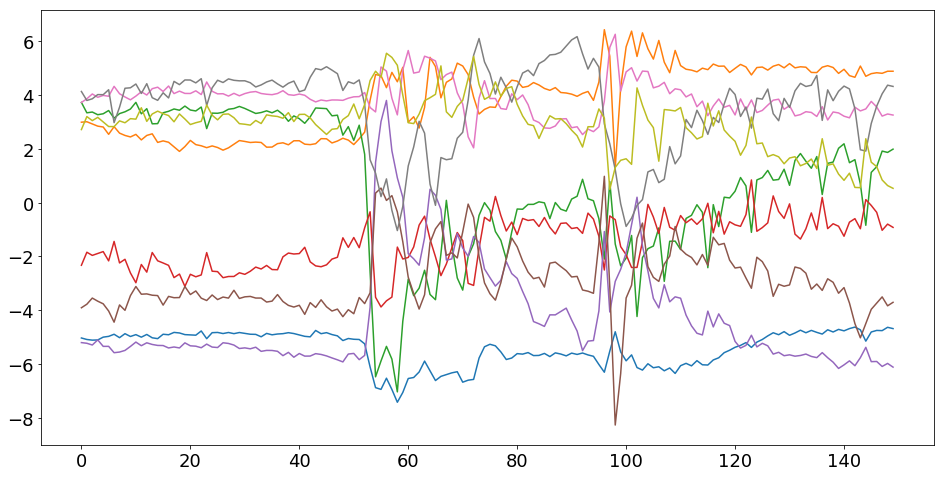

In [26]:
plt.plot(traces_ae[0])

In [ ]:
from behavenet.fitting.utils import get_subdirs
import os
          
def latent_results(expt_name=None):
    # set model info
    sess_idx = 0
    hparams = {
        'data_dir': get_user_dir('data'),
        'save_dir': get_user_dir('save'),
        'model_class': 'neural-ae',
        'ae_model_type': 'conv',
        'ae_experiment_name': 'latent_search',
        'n_ae_latents': 9,
        'experiment_name':'grid_search',
        'model_type':'ff',
        'n_max_lags': 8
    }

    hparams['neural_ae_experiment_name'] = hparams['experiment_name']
    hparams['neural_ae_model_type'] = hparams['model_type']
    
    get_lab_example(hparams, 'dipoppa', SESS_ID)
    
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    expt_dir = get_expt_dir(hparams)

    ## Get discrete chance performance (accuracy of always predicting the most common training state)
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    mean_ae_latents = np.mean(np.concatenate([all_latents['latents'][i] for i in all_latents['trials']['train']]),axis=0)

    all_test_latents = np.concatenate([all_latents['latents'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    chance_ae_performance = np.mean((all_test_latents-mean_ae_latents)**2)
    
    ## Get discrete prediction performance
    # If sub-sampling - make sure to get results labelled by sample method and index name 
    if expt_name is not None:
        hparams['subsample_method'] = 'single'
        hparams['subsample_idxs_name'] = expt_name
    
    _, latent_predictions_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])
    with open(latent_predictions_file, 'rb') as f:
        all_latent_predictions = pickle.load(f)
    all_test_latent_predictions = np.concatenate([all_latent_predictions['predictions'][i][hparams['n_max_lags']:-hparams['n_max_lags']] for i in all_latents['trials']['test']])
    decoding_ae_performance = np.mean((all_test_latents-all_test_latent_predictions)**2)
    
    return chance_ae_performance, decoding_ae_performance


In [4]:
def rsquared(SSres, SStot):
    return 1 - (SSres / SStot)
def avg_dict(d):
    return np.array([np.mean(d[j]) for j in d])

# Decoding across cell types

In [8]:
#Inhibitory Decoding Performance (SST Neurons):
chance_performance, inh_decoding_performance = latent_results(expt_name='inh_all')
# inh_decoding_performance = rsquared(inh_decoding_performance, chance_performance)

#Excitatory Decoding Performance:
sample_sizes = range(50)
exc_decoding_errors = []
for size in sample_sizes:
    chance_performance, decoding_performance = latent_results(expt_name='exc85_sample_{}'.format(size))
    exc_decoding_errors.append(decoding_performance)
    
exc_decoding_errors /= chance_performance
inh_decoding_performance /= chance_performance


TypeError: list indices must be integers or slices, not str

In [2]:
plt.title('[Session #{}] Mean Squared Error Distribution Over 50 Trials'.format(SESS_NUM))
sns.distplot(exc_decoding_errors, color='red', bins=10, label='85 Putative Excitatory Neurons')

# percentile = exc_decoding_errors.copy()
# percentile.append(inh_decoding_performance)
# percentile.sort()
# inh_percentile = (percentile.index(inh_decoding_performance) - 1) / len(percentile) * 100

p_val = scipy.stats.ttest_1samp(exc_decoding_errors, chance_performance)
print(p_val[0], p_val[1])

plt.axvline(inh_decoding_performance, color='b', label='85 SST Neurons')
plt.axvline(1, color='y', label='Chance decoding performance')
plt.legend()

# print(np.percentile(percentile, 4.3), inh_decoding_performance)
# print('Percentile SST: %d' % inh_percentile)

NameError: name 'plt' is not defined

In [7]:
SESS_ID = 'full_trial'
SESS_NUM = '1'

# Inhibitory Decoding vs. Chance

# Decoding by number of neurons

In [8]:
from scipy.stats import sem
def std_error(sample):
    return np.array([sem(i) for i in sample.values()])

In [9]:
def plot_log(data, x=None, lines=[], label1="", xlabel="", ylabel="", title=""):
    if isinstance(data, dict):
        data = avg_dict(data)
    
    fig, ax = plt.subplots(figsize=(16,8))
    
    std_err = sem(data)
    plt.loglog(x, data, label=label1)   
        
    # Calculate slope and plot line 
    slope, intercept = np.polyfit(np.log2(x), np.log2(data), 1)
    abline_values = [slope * i + intercept for i in np.log2(x)]
    plt.plot(x, np.power(2, abline_values), '-', color='k', label=label1 + ' Line of Best Fit ' + r'($\alpha$=%.3f)'%slope)  
    
    print(std_err)
    # Fill in standard deviation error shading
    plt.fill_between(x, data + std_err, data-std_err, color='b', label=label1 + ' std. error', alpha=0.2)
    
    plt.hlines(lines[0], xmin=0, xmax=max(x), linestyles='--', label='Chance Level Performance')
    
    # plt.errorbar(x, data, yerr=std_err)
    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.title(title)

In [16]:
sample_sizes = [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200,1452]
decoding_errors_dict = {}
for i, SESS_NUM in enumerate(['1', '2', '3', '4']):
    decoding_errors_dict[i] = {}
    for _, size in enumerate(sample_sizes):
        decoding_errors_dict[i][size] = []
        for t in range(10):
            chance_performance, decoding_performance = latent_results(expt_name='sample_{}_t{}'.format(size, t))
            decoding_errors_dict[i][size].append(decoding_performance)

In [17]:
decoding_errors_dict.keys()

dict_keys([0, 1, 2, 3])

In [22]:
from scipy import stats

def avg_dict(data):
    return np.array([np.mean(data[i]) for i in data])

def plot_log(data, xticks, ax, std_error=None, session=1, log=True, measure='MSE', best_fit='plot'):
    print(data, xticks, ax)
    ax.plot(xticks, data)
    
    # Calculate Line of Best Fit 
    slope, intercept = np.polyfit(np.log(xticks), np.log(data), 1)
    abline_values = [slope * i + intercept for i in np.log(xticks)]
    if best_fit == 'plot':
        ax.plot(xticks, np.power(np.e, abline_values), '--', color='k', label=r'Line of Best Fit, $\alpha=%.3f$'%(slope))
    
    # Fill in standard error
    if not std_error is None:
        plt.fill_between(xticks, data+std_error, data-std_error, label='[Session #{}] Std. Err'.format(session), alpha=0.3)
    
    if log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    ax.set_xlabel('Number of Neurons')
    if measure == 'r2':
        measure = r'$R^2$'
    ax.set_ylabel(measure)
    ax.set_title('Pupil Decoding Error by Number of Neurons')
    
    if best_fit == 'average':
        # Return best fit values for averaging
        return slope, abline_values
    
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()

ax.plot([1,2,3,4])
plt.show()

measure = 'mse' # 'mse' for Mean Squared Error or 'r2' for R^2
best_fit = 'average' # 'average' returns line of best fit values for averaging | 'plot' plots individual lines
best_fits = []
slopes = []
start_index = 0 # Index to start plotting from

for i in range(4):
    # Calculate standard errors
    std_error = np.array([stats.sem(decoding_errors_dict[i][k]) for k in decoding_errors_dict[i]])[start_index:]
    # Average errors across all tests in a sample size
    avg_errors = avg_dict(decoding_errors_dict[i])[start_index:]
    
    if best_fit == 'average':
        slope, abline_vals = plot_log(avg_errors, 
                                      sample_sizes[start_index:], 
                                      ax, 
                                      std_error=std_error, 
                                      best_fit='average', 
                                      measure=measure, 
                                      session=i+1)
        slopes.append(slope)
        best_fits.append(abline_vals)
    else:
        plot_log(avg_errors, 
                 sample_sizes[start_index:], 
                 ax, std_error=std_error, 
                 measure=measure, 
                 session=i+1)
    
# Average line of best fit
if best_fit == 'average':
    slope = np.mean(slopes)
    abline_values = np.mean(best_fits, axis=0)
    ax.plot(sample_sizes[start_index:], np.power(np.e, abline_values), '--', color='k', label=r'Line of Best Fit, $\alpha=%.3f$'%(slope))

# Remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


AttributeError: 'NoneType' object has no attribute 'plot'

<Figure size 1152x576 with 0 Axes>

In [34]:
from behavenet.fitting.utils import build_data_generator

hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'model_class': 'neural-ae',
    'ae_model_type': 'conv',
    'ae_experiment_name': 'latent_search',
    'n_ae_latents': 9,
    'experiment_name':'grid_search',
    'model_type':'ff',
    'n_max_lags': 8,
    'device': 'cpu',
    'as_numpy': False,
    'batch_load': True, # type: boolean
    'rng_seed_data': 0, # type: int, help: controls data splits
    'train_frac': 1.0, # type: float, help: fraction of data
    'trial_splits': '8;1;1;0' # type: str, help: i;j;k;l correspond to train;val;test;gap'
}

hparams['neural_ae_experiment_name'] = hparams['experiment_name']
hparams['neural_ae_model_type'] = hparams['model_type']

get_lab_example(hparams, 'dipoppa', SESS_ID)

hparams['session_dir'], sess_ids = get_session_dir(hparams)
expt_dir = get_expt_dir(hparams)

data_gen = build_data_generator(hparams, sess_ids)

using data from following sessions:
/home/samsung_2tb_ssd/yoni/results/dipoppa/full_trial/MD0ST5/1
constructing data generator...

KeyError: 'expt_dir'

In [21]:
sample_sizes = [1, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 85]
sst_decoding_dict = {}
exc_decoding_dict = {}
for i, size in enumerate(sample_sizes):
    sst_decoding_dict[size] = []
    exc_decoding_dict[size] = []
    for t in range(10):
        chance_performance, sst_decoding = latent_results(expt_name='sst{}_sample_{}'.format(size, t))
        sst_decoding_dict[size].append(decoding_performance)

title='[Session #%s] AE Latent Decoding by Number of Neurons' % SESS_NUM        
plot_log(decoding_errors_dict, x=sample_sizes, lines=[chance_performance],
         label1='', xlabel='Number of Neurons', ylabel='MSE', title=title)

FileNotFoundError: [Errno 2] No such file or directory: '/home/samsung_2tb_ssd/yoni/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sst1_sample_0-single/grid_search/version_1/dipoppa_full_trial_MD0ST5_1_predictions.pkl'

In [63]:
SESS_ID='session_1'
SESS_NUM='1'

# Standard Decoding Plot (ARHMM, AE)

# Single Neuron Decoding

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
sample_sizes = list(range(20))
decoding_errors = []
for size in sample_sizes:
    chance_performance, decoding_performance = latent_results(sample_size=size, expt_name='exc85_sample')
    decoding_errors.append(decoding_performance)

avg_error = sum(decoding_errors) / 20

plt.hlines(chance_performance, 0, 20, color='blue', label='Chance (Mean) Behavioral State Prediction')   
plt.title('AE Latent Decoding for Single Neurons', fontsize=22)
plt.plot(sample_sizes, decoding_errors, '-o', label='Latent Behavioral State Prediction')
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Mean Squared Error', fontsize=18)
plt.legend()
plt.show()

## Plot true vs predicted latents

[Back to contents](#Contents)

In [130]:
def plot_real_vs_predicted(
        latents, latents_predicted, save_file=None, xtick_locs=None,  frame_rate=None, format='png'):
    """Plot real and sampled latents overlaying real and (potentially sampled) states.
    Parameters
    ----------
    latents : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    latents_samp : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    states : :obj:`np.ndarray`
        shape (n_frames,)
    states_samp : :obj:`np.ndarray`
        shape (n_frames,) if :obj:`latents_samp` are not conditioned on :obj:`states`, otherwise
        shape (0,)
    save_file : :obj:`str`
        full save file (path and filename)
    xtick_locs : :obj:`array-like`, optional
        tick locations in bin values for plot
    frame_rate : :obj:`float`, optional
        behavioral video framerate; to properly relabel xticks
    format : :obj:`str`, optional
        any accepted matplotlib save format, e.g. 'png' | 'pdf' | 'jpeg'
    Returns
    -------
    :obj:`matplotlib.figure.Figure`
        matplotlib figure handle
    """

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        
    spc = 1.1 * abs(latents.max())
    n_latents = latents.shape[1]
    plotting_latents = latents + spc * np.arange(n_latents)
    plotting_predicted_latents = latents_predicted + spc * np.arange(n_latents)
    ymin = min(-spc - 1, np.min(plotting_latents))
    ymax = max(spc * n_latents, np.max(plotting_latents))
    ax.plot(plotting_latents, '-k', lw=3, label='AE Latents')
    ax.plot(plotting_predicted_latents, '-g', lw=3, label='Predicted AE latents')
    ax.set_ylim([ymin, ymax])

    ax.set_yticks([])

    ax.set_xlabel('Time (bins)')

    if xtick_locs is not None:
        ax.set_xticks(xtick_locs)
        if frame_rate is not None:
            ax.set_xticklabels((np.asarray(xtick_locs) / frame_rate).astype('int'))
            ax.set_xlabel('Time (sec)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

    if save_file is not None:
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file, dpi=300, format=format)


In [ ]:
import os

# user params
get_best_version = True  # False when looking at multiple models w/in a tt expt
dtype = 'val'  # data type to draw trials from: 'train' | 'val' | 'test'
sess_idx = 0  # when using a multisession, this determines which session is used
max_frames = 200

# define which arhmm states to plot (must already be fit)
n_arhmm_states = [4, 8]

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'model_type': 'ff',
    'ae_experiment_name': 'latent_search',
    'n_ae_latents': 9,
    'ae_model_type': 'conv',
}

hparams['neural_ae_experiment_name'] = hparams['experiment_name']
hparams['neural_ae_model_type'] = hparams['model_type']

get_lab_example(hparams, 'dipoppa', SESS_ID)

xtick_locs = [0, 30, 60, 90, 120, 150, 180]
frame_rate = 30
n_trials = 10
           
for n_states in n_arhmm_states:
        
    hparams['n_arhmm_states'] = n_states
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    hparams['expt_dir'] = get_expt_dir(hparams)
    
    # get version/model
    if get_best_version:
        version = get_best_model_version(
            hparams['expt_dir'], measure='val_loss', best_def='max')[0]
    else:
        _, version = experiment_exists(hparams, which_version=True)

    # load model
    model_file = os.path.join(
        hparams['expt_dir'], 'version_%i' % version, 'best_val_model.pt')
    with open(model_file, 'rb') as f:
        hmm = pickle.load(f)
        
            
    # load latents
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    
    _, latents_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])

    # choose which trials to plot
    np.random.seed(0)
    trial_vec = np.random.choice(
        np.arange(0, len(all_latents['trials'][dtype])), size=(n_trials,), 
        replace=False)

    with open(latents_file, 'rb') as f:
        predicted_latents = pickle.load(f)

    model_name = str(
        'latent_prediction_D=%02i' % (
        hparams['n_ae_latents']))

    if save_outputs:
        save_file = os.path.join(
            get_user_dir('fig'), hparams['model_class'], model_name + '.' + format)
    else:
        save_file = None
    
    plot_real_vs_predicted(all_latents['latents'][trial_vec[0]], predicted_latents['predictions'][trial_vec[0]], save_file=save_file, xtick_locs=None,  frame_rate=30, format='png')
    plt.title('Latent Reconstruction (85 Random Excitatory Neurons)')
    

# Let's create a helpful method to visualize how we've decoded across multiple regions

In [ ]:
def plot_real_vs_predicted_subsampling(
        latents, latents_predicted, save_file=None, xtick_locs=None,  frame_rate=None, format='png'):
    """Plot real and sampled latents overlaying real and (potentially sampled) states.
    Parameters
    ----------
    latents : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    latents_samp : :obj:`np.ndarray`
        shape (n_frames, n_latents)
    states : :obj:`np.ndarray`
        shape (n_frames,)
    states_samp : :obj:`np.ndarray`
        shape (n_frames,) if :obj:`latents_samp` are not conditioned on :obj:`states`, otherwise
        shape (0,)
    save_file : :obj:`str`
        full save file (path and filename)
    xtick_locs : :obj:`array-like`, optional
        tick locations in bin values for plot
    frame_rate : :obj:`float`, optional
        behavioral video framerate; to properly relabel xticks
    format : :obj:`str`, optional
        any accepted matplotlib save format, e.g. 'png' | 'pdf' | 'jpeg'
    Returns
    -------
    :obj:`matplotlib.figure.Figure`
        matplotlib figure handle
    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        
    spc = 1.1 * abs(latents.max())
    n_latents = latents.shape[1]
    for latent, latent_predicted in zip(latents, latent_predicted):
        plotting_latents = latent + spc * np.arange(n_latents)
        plotting_predicted_latents = latent_predicted + spc * np.arange(n_latents)
        ymin = min(-spc - 1, np.min(plotting_latents))
        ymax = max(spc * n_latents, np.max(plotting_latents))
        ax.plot(plotting_latents, '-k', lw=3, label='AE Latents')
        ax.plot(plotting_predicted_latents, lw=3, label='Predicted AE latents')
        ax.set_ylim([ymin, ymax])

    ax.set_yticks([])

    ax.set_xlabel('Time (bins)')

    if xtick_locs is not None:
        ax.set_xticks(xtick_locs)
        if frame_rate is not None:
            ax.set_xticklabels((np.asarray(xtick_locs) / frame_rate).astype('int'))
            ax.set_xlabel('Time (sec)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='center left', bbox_to_anchor=(1, 0.5))

    if save_file is not None:
        make_dir_if_not_exists(save_file)
        plt.savefig(save_file, dpi=300, format=format)


In [ ]:
# user params
get_best_version = True  # False when looking at multiple models w/in a tt expt
dtype = 'test'  # data type to draw trials from: 'train' | 'val' | 'test'
sess_idx = 0  # when using a multisession, this determines which session is used
max_frames = 200

# define which arhmm states to plot (must already be fit)
n_arhmm_states = [2, 4]

# set model info
hparams = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'experiment_name': 'grid_search',
    'model_class': 'neural-ae',
    'model_type': 'ff',
    'ae_experiment_name': 'latent_search',
    'n_ae_latents': 9,
    'ae_model_type': 'conv',
}

hparams['neural_ae_experiment_name'] = hparams['experiment_name']
hparams['neural_ae_model_type'] = hparams['model_type']

get_lab_example(hparams, 'dipoppa', SESS_ID)

xtick_locs = [0, 30, 60, 90, 120, 150, 180]
frame_rate = 30
n_trials = 10
           
for n_states in n_arhmm_states:
        
    hparams['n_arhmm_states'] = n_states
    hparams['session_dir'], sess_ids = get_session_dir(hparams)
    hparams['expt_dir'] = get_expt_dir(hparams)
    print(hparams['expt_dir'])
    # get version/model
    if get_best_version:
        version = get_best_model_version(
            hparams['expt_dir'], measure='val_loss', best_def='max')[0]
    else:
        _, version = experiment_exists(hparams, which_version=True)

    # load model
    model_file = os.path.join(
        hparams['expt_dir'], 'version_%i' % version, 'best_val_model.pt')
    with open(model_file, 'rb') as f:
        hmm = pickle.load(f)
        
            
    # load latents
    _, latents_file = get_transforms_paths('ae_latents', hparams, sess_ids[sess_idx])
    with open(latents_file, 'rb') as f:
        all_latents = pickle.load(f)
    
    _, latents_file = get_transforms_paths('neural_ae_predictions', hparams, sess_ids[sess_idx])

    # choose which trials to plot
    np.random.seed(0)
    trial_vec = np.random.choice(
        np.arange(0, len(all_latents['trials'][dtype])), size=(n_trials,), 
        replace=False)

    with open(latents_file, 'rb') as f:
        predicted_latents = pickle.load(f)

    model_name = str(
        'latent_prediction_D=%02i' % (
        hparams['n_ae_latents']))

    if save_outputs:
        save_file = os.path.join(
            get_user_dir('fig'), hparams['model_class'], model_name + '.' + format)
    else:
        save_file = None

    plot_real_vs_predicted(all_latents['latents'][trial_vec[0]], predicted_latents['predictions'][trial_vec[0]], save_file=save_file, xtick_locs=None,  frame_rate=30, format='png')


In [ ]:
SESS_ID = 'session_3'
SESS_NUM = '3'

Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/all/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/inh_all-single/grid_search/version_1/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/inh_all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/exc85_sample_0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/exc85_sample_0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sample_100_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/sample_100_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sample_500_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/sample_500_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_1
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/1/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/ae/conv/09_latents/latent_search/version_0/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/1/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/1/sample_1000_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/inh_all-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/inh_all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/exc85_sample_0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/exc85_sample_0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/sample_100_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/sample_100_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/sample_500_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/sample_500_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_2
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/2/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/2/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/2/sample_1000_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/inh_all-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/inh_all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/exc85_sample_0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/exc85_sample_0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/sample_100_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/sample_100_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/sample_500_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/sample_500_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_3
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/3/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/3/sample_1000_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/inh_all-single/grid_search/version_0/meta_tags.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/inh_all_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/exc85_sample_0-single/grid_search/version_0/meta_tags.pkl


/home/yoni/.conda/envs/behavenet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/exc85_sample_0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/sample_100_t0-single/grid_search/version_0/meta_tags.pkl


/home/yoni/.conda/envs/behavenet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/sample_100_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/sample_500_t0-single/grid_search/version_0/meta_tags.pkl


/home/yoni/.conda/envs/behavenet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/sample_500_t0_D=09_reconstruction.mp4...done
Generator contains 1 SingleSessionDatasetBatchedLoad objects:
dipoppa_full_trial_MD0ST5_4
    signals: ['images']
    transforms: OrderedDict([('images', None)])
    paths: OrderedDict([('images', '/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/4/data.hdf5')])

Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/ae/conv/09_latents/latent_search/version_1/meta_tags.pkl
Loading model defined in /home/yoni/behavenet/results/dipoppa/full_trial/MD0ST5/4/neural-ae/09_latents/ff/sample_1000_t0-single/grid_search/version_0/meta_tags.pkl


/home/yoni/.conda/envs/behavenet/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


processing frame 000/150
processing frame 100/150
saving video to /home/yoni/behavenet/figures/neural-ae/full_trial/MD0ST5/4/sample_1000_t0_D=09_reconstruction.mp4...done


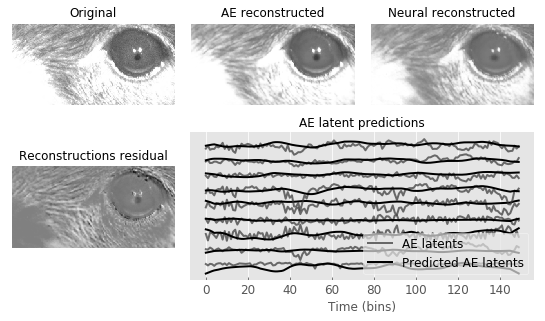

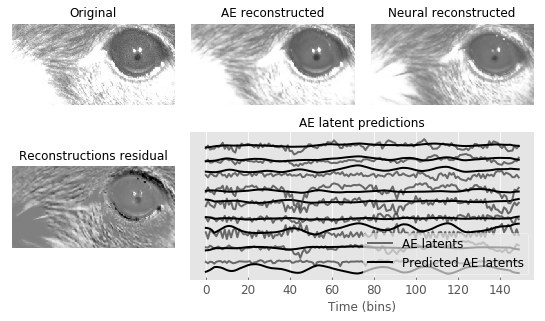

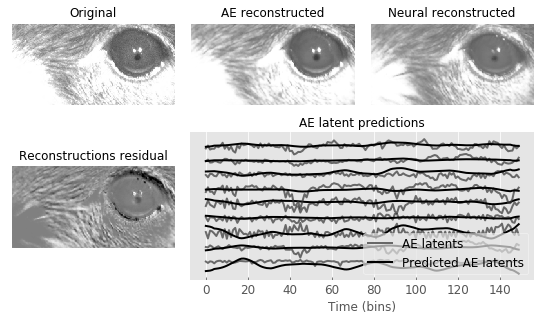

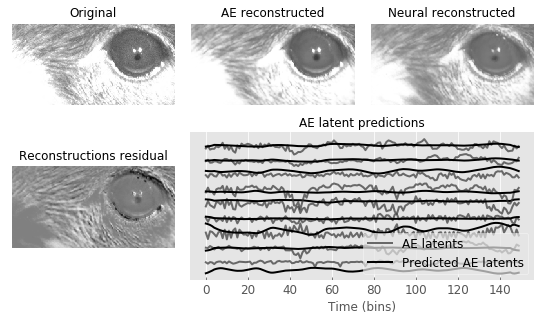

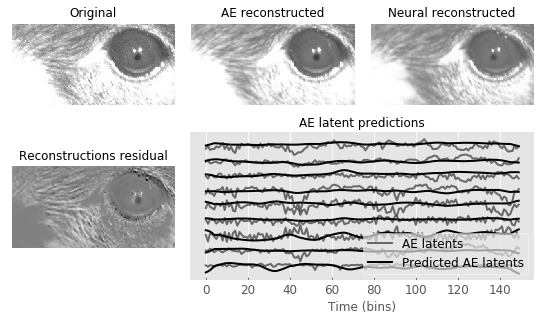

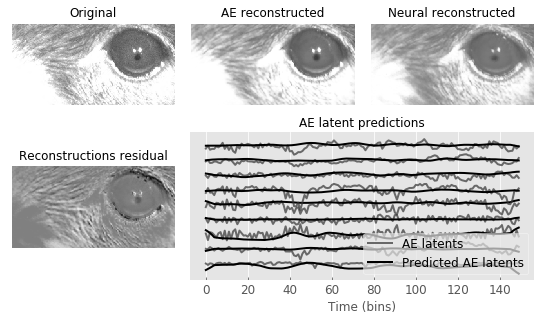

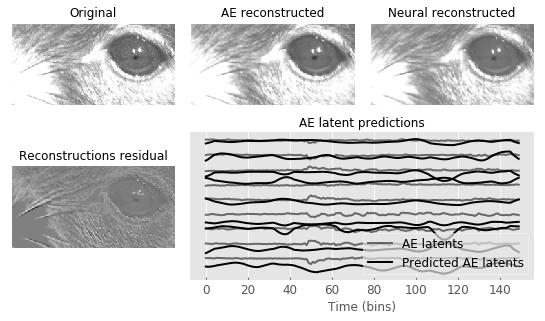

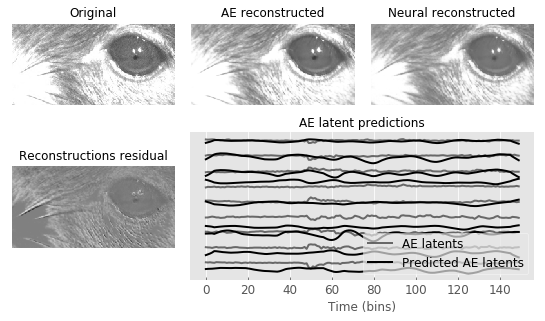

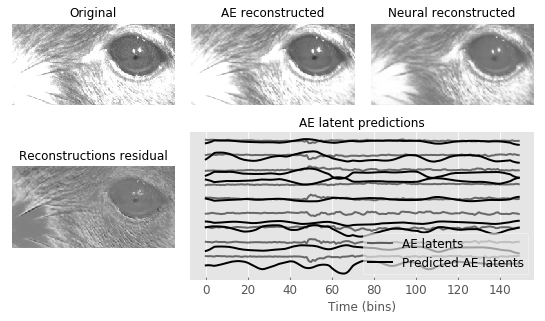

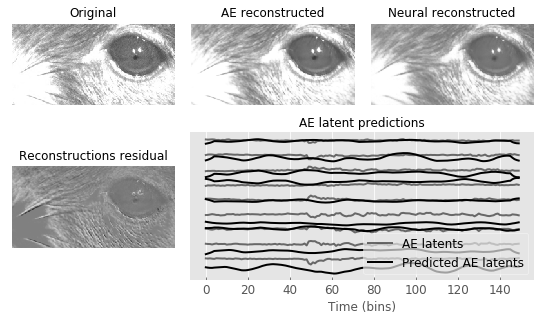

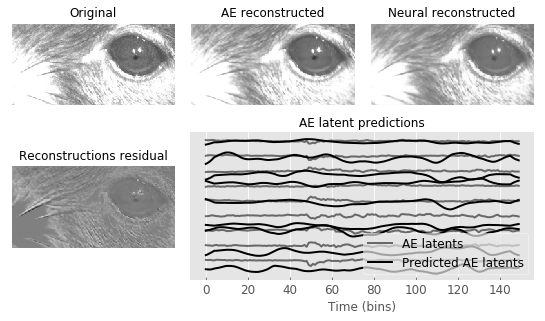

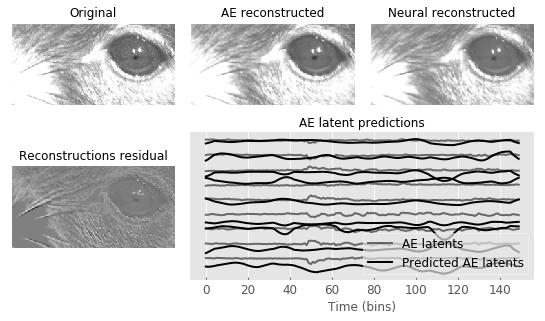

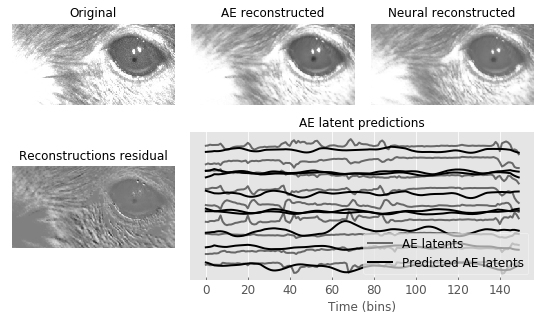

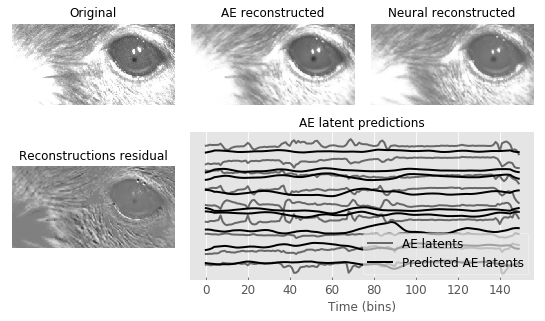

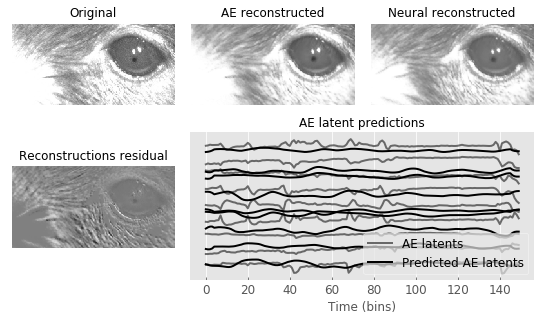

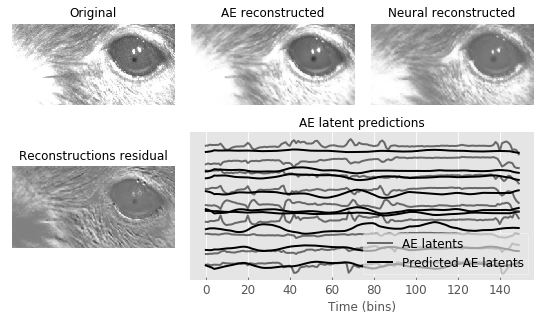

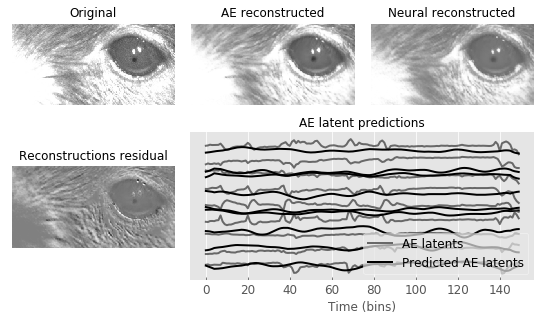

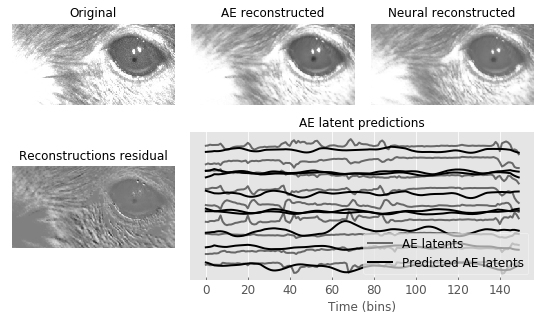

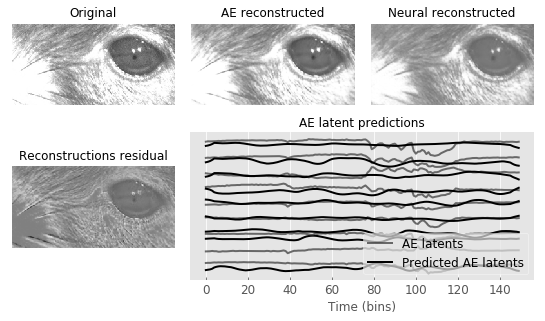

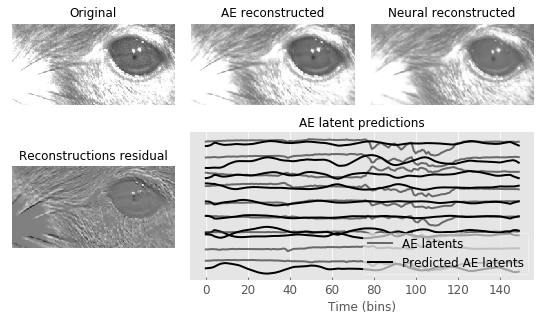

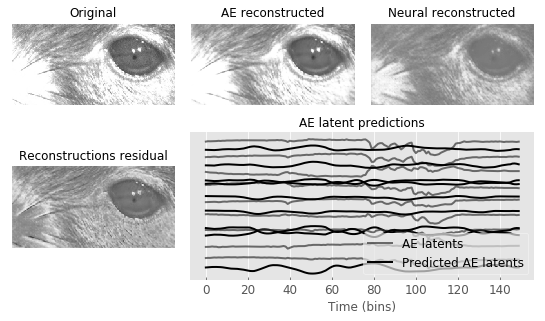

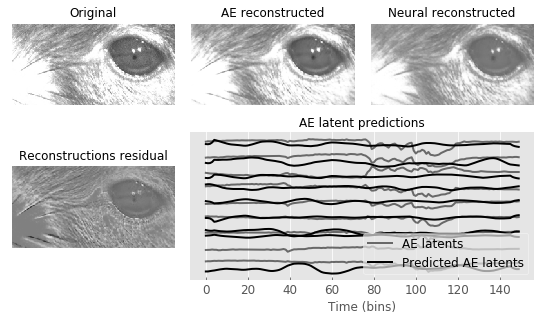

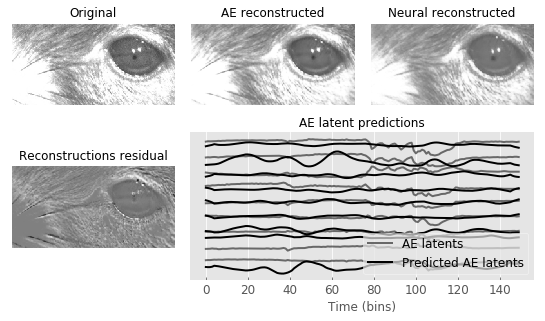

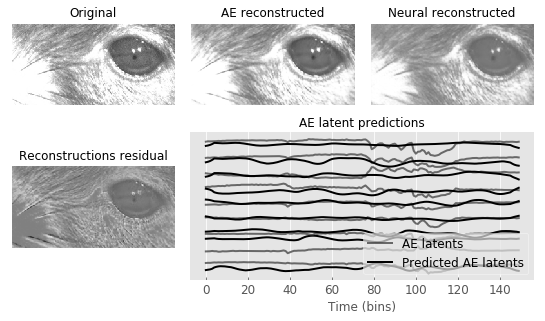

In [76]:
from behavenet.plotting.ae_utils import make_neural_reconstruction_movie_wrapper
from behavenet.data.utils import get_data_generator_inputs
from behavenet.data.data_generator import ConcatSessionsGenerator

# movie info
save_outputs = True
include_linear = False  # True to include reconstructions from linear models; need training

# set model info
version = 'best'  # test-tube version; 'best' finds the version with the lowest mse
sess_idx = 0  # when using a multisession, this determines which session is used
MASTER_HPARAMS = {
    'data_dir': get_user_dir('data'),
    'save_dir': get_user_dir('save'),
    'model_class': 'ae',
    'experiment_name': 'grid_search',
    'model_type': 'ff',
    'ae_model_class': 'ae',
    'ae_model_type': 'conv',
    'ae_version': version,
    'noise_type': 'gaussian',
    'n_arhmm_lags': 1,
    'kappa': 0,
    'ae_experiment_name': 'latent_search',
    'n_ae_latents': 9,
    'neural_arhmm_experiment_name':'grid_search',
    'n_arhmm_states': 4,
    'n_max_lags': 9,
    'decoder_experiment_name': 'grid_search',
    'decoder_model_class': 'neural-ae',
    'decoder_model_type': 'ff',
    'decoder_version': version
}

sess_ids = ['session_1', 'session_2', 'session_3', 'full_trial']
sess_nums = ['1', '2', '3', '4']
expts = ['all', 'inh_all', 'exc85_sample_0', 'sample_100_t0', 'sample_500_t0', 'sample_1000_t0']
for SESS_ID, SESS_NUM in zip(sess_ids, sess_nums):
    for expt_name in expts:
        hparams = MASTER_HPARAMS
        # programmatically fill out other hparams options
        get_lab_example(hparams, 'dipoppa', SESS_ID)   
        hparams['session_dir'], sess_ids = get_session_dir(hparams)
        hparams['expt_dir'] = get_expt_dir(hparams)
        
        if expt_name != 'all':
            hparams['subsample_method'] = 'single'
            hparams['subsample_idxs_name'] = expt_name

        # load data generator to find a test trial
        hparams, signals, transforms, paths = get_data_generator_inputs(hparams, sess_ids)
        data_generator = ConcatSessionsGenerator(
            hparams['data_dir'], sess_ids, 
            signals_list=signals, transforms_list=transforms, paths_list=paths,
            device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
        print(data_generator)
        trial = data_generator.datasets[sess_idx].batch_idxs['test'][2]  # trial to use in movie

        filename = str('%s_D=%02i_reconstruction' % (expt_name, hparams['n_ae_latents']))

        make_neural_reconstruction_movie_wrapper(
            hparams, 
            save_file=os.path.join(get_user_dir('fig'), 'neural-ae', 'full_trial', 'MD0ST5', SESS_NUM, filename), 
            frame_rate=30, max_latents=9, trial=trial)